In [7]:
# Step 3: Data Loading 
import pandas as pd 

breast_cancer = pd.read_csv('breast-cancer.data', header=None)
ecoli = pd.read_csv('ecoli.data', header=None, delim_whitespace=True)
transfusion = pd.read_csv('transfusion.data')

breast_cancer.columns = ['class','age','menopause','tumor-size','inv-nodes',
                         'node-caps','deg-malig','breast','breast-quad','Radiation']
ecoli.columns = ['sequence','mcg','gvh','lip','chg','aac','alm1','alm2','class']

transfusion = transfusion.rename(columns= {'whether he/she donated blood in March 2007': 'label'})


In [8]:
# Step 4: Data Analysis

breast_cancer.head()
#breast_cancer.value_counts()  # reveals all cols categorical 
#breast_cancer.describe()  # reveals deg-malig mean/std/min/max

#ecoli.head()  # reveals numerical vs categorical 
#ecoli.info()  # reveals categorial vs numerical type 
#ecoli.describe()

#transfusion.head()
#transfusion.info()
#transfusion.describe()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,Radiation
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


**breast_cancer**

Almost all features in the cancer dataset are categorial (aside from 'deg-malig'), so they will need converting into numerical form. The conversions for 'class', 'menopause', 'inv-nodes', 'breast' and 'label' can be hot-encoded as binary [0,1]. The remaining features will require multiple values because they hold multiple categorical values. 

The only numerical feature, deg-malig, has a mean of 2.04 and std dev of 0.74. It's min and max vals are 1 and 3 respectively so it will not require rescaling. 

**ecoli**

All features except 'sequence' and 'Label' in the ecoli dataset are numerical. The minimum values for each numerical feature range from 0.0 to 0.5 and the maximum values range from 0.88 to 1.0. Each feature has a mean around 0.5 and a std dev of less than 0.21. Therefore rescaling is not necessary for these numerical data. 

**transfusion** 

All features in the transfusions data set are numerical. 'Monetary' feature is significantly larger (mean = 1379) than the other features whose mean averages less than 10. 

In [9]:
# Step 5: Feature preprocessing 
from sklearn.preprocessing import LabelEncoder

# Pt I: Data imputation, Handling missing data
transfusion[(transfusion.isna().any(axis=1))]  # no NaNs found so no mods needed
#breast_cancer = breast_cancer[-((breast_cancer=='?').any(axis=1))]
ecoli[(ecoli.isna().any(axis=1))]  # no NaNs found so no mods needed 

# Pt II: Convert textual/categorical column into numeric numbers
le = LabelEncoder()  # instantiate instance of label encoder 

df_shape = breast_cancer.shape  # store shape of df 
for i in range(df_shape[1]): 
  breast_cancer.iloc[:,i] = le.fit_transform(breast_cancer.iloc[:,i])

breast_cancer_encoded = breast_cancer.drop('class', axis=1)  # create X df 
breast_cancer_labels = breast_cancer['class']  # create Y df 

df_shape = ecoli.shape  # store shape of df 
ecoli_features = ecoli.drop('sequence', axis=1)  # drop sequence col (unneeded)
ecoli_features = ecoli_features.drop('class', axis=1)  # create X df 

ecoli_labels = le.fit_transform(ecoli['class'])  # encode Y df 

df_shape = transfusion.shape
for i in range(df_shape[1]): 
  transfusion.iloc[:,i] = le.fit_transform(transfusion.iloc[:,i])

transfusion_features = transfusion.drop('label', axis=1)  # create X df 
transfusion_labels = transfusion['label']  # create Y df

# Pt III: Normalization (optional)

breast_cancer_encoded

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,Radiation
0,1,2,5,0,1,2,0,2,0
1,2,2,3,0,1,1,1,5,0
2,2,2,3,0,1,1,0,2,0
3,4,0,2,0,1,1,1,3,0
4,2,2,0,0,1,1,1,4,0
...,...,...,...,...,...,...,...,...,...
281,1,2,5,0,1,1,0,3,0
282,1,2,3,0,1,2,0,3,1
283,4,0,3,0,1,0,1,3,0
284,2,0,5,4,1,2,0,2,0


In [ ]:
# Step 6: Design k-NN classifier w hyper-parameter tuning and model selection 
import numpy as np 
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import scipy.spatial.distance as distance
from sklearn.model_selection import RepeatedKFold

# define chi_sq distance for kNN classifier distance 
def chi_square_distance(X, Y):
    with np.errstate(divide="ignore", invalid="ignore"):
        return (1 / 2) * np.sum(np.nan_to_num((np.square(X - Y) / (X + Y))))

# init array to hold K values
n_neighbors = [int(x) for x in np.linspace(1, 15, num = 15)]  
# init four distance metrics 
metric = [chi_square_distance, distance.euclidean, distance.minkowski, 
          distance.cosine]
# init dictionary to hold 
param_distribs = {'n_neighbors':n_neighbors,'metric': metric}
# instantiate kNN classifier 
estimator = KNeighborsClassifier()
# 10 fold cross validation 
skfold = RepeatedKFold(n_splits=10,n_repeats=10,random_state=1)
# search param space 
grid_search = GridSearchCV(estimator, param_distribs, n_jobs=5,cv=skfold)
# fit search to X and Y data (breast cancer)
grid_search.fit(breast_cancer_encoded, breast_cancer_labels)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10, random_state=1),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=5,
             param_grid={'metric': [<function chi_square_distance at 0x7ff2a9154710>,
                                    <function euclidean at 0x7ff2b68a7d40>,
                                    <function minkowski at 0x7ff2b68a7c20>,
                                    <function cosine at 0x7ff2b68a7ef0>],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_

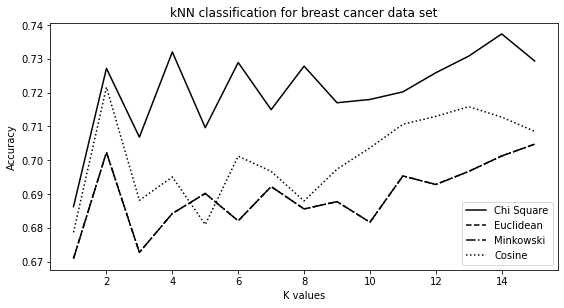

In [ ]:
# Step 7: Analysis Results from Cross-validation
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance

# define chi_sq distance for kNN classifier distance 
def chi_square_distance(X, Y):
    with np.errstate(divide="ignore", invalid="ignore"):
        return (1 / 2) * np.sum(np.nan_to_num((np.square(X - Y) / (X + Y))))

# Pt I: Create a df from the cv_resutls
df_cv = pd.DataFrame(grid_search.cv_results_)
df_cv12 = df_cv[['param_n_neighbors', 'param_metric', 'mean_test_score']]

# break new df into subclasses by distance measure  
chi_sq = df_cv12[df_cv12['param_metric'].astype(str).str.contains("chi_square")].reset_index(drop=True)
euclid = df_cv12[df_cv12['param_metric'].astype(str).str.contains("euclidean")].reset_index(drop=True)
minkowski = df_cv12[df_cv12['param_metric'].astype(str).str.contains("minkowski")].reset_index(drop=True)
cosine = df_cv12[df_cv12['param_metric'].astype(str).str.contains("cosine")].reset_index(drop=True)

# Pt II: Visualize the results (with values of K on the x-axis and accuracy on 
# the y-axis) for all four metrics over three datasets using matplotlib. 

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)  
plt.plot(chi_sq['param_n_neighbors'], chi_sq['mean_test_score'], 
         label = 'Chi Square', color = 'k')
plt.plot(euclid['param_n_neighbors'], euclid['mean_test_score'], 
         label = 'Euclidean', color = 'k', linestyle = '--')
plt.plot(minkowski['param_n_neighbors'], minkowski['mean_test_score'], 
         label = 'Minkowski', color = 'k', linestyle = '-.')
plt.plot(cosine['param_n_neighbors'], cosine['mean_test_score'], 
         label = 'Cosine', color = 'k', linestyle = ':')
plt.title('kNN classification for breast cancer data set')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


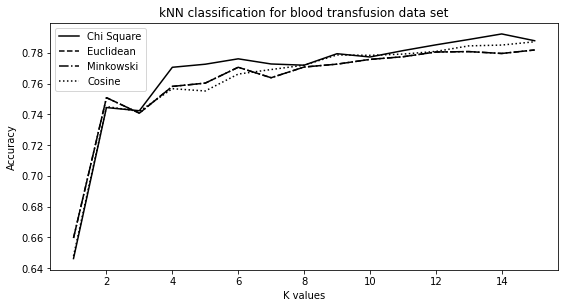

In [ ]:
# Repeat Steps 6 and 7 for blood data sets 
import numpy as np 
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import scipy.spatial.distance as distance
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# define chi_sq distance for kNN classifier distance 
def chi_square_distance(X, Y):
    with np.errstate(divide="ignore", invalid="ignore"):
        return (1 / 2) * np.sum(np.nan_to_num((np.square(X - Y) / (X + Y))))

# init array of int [1:15] inclusive
num_nhbrs = np.arange(1,16)   
# init four distance metrics 
metric = [chi_square_distance, distance.euclidean, distance.minkowski, 
          distance.cosine]
# init dictionary to hold 
param_distribs = {'n_neighbors':num_nhbrs, 'metric': metric}
# instantiate kNN classifier 
estimator2 = KNeighborsClassifier()
# 10 fold cross validation 
skfold2 = RepeatedKFold(n_splits=10,n_repeats=10,random_state=1)
# search param space 
grid_search2 = GridSearchCV(estimator2, param_distribs, n_jobs=5,cv=skfold2)
# fit search to X and Y data (breast cancer)
grid_search2.fit(transfusion_features, transfusion_labels)


# Pt I: Create a df from the cv_resutls
df_cv = pd.DataFrame(grid_search2.cv_results_)
df_cv22 = df_cv[['param_n_neighbors', 'param_metric', 'mean_test_score']]

# break new df into subclasses by distance measure  
chi_sq = df_cv22[df_cv22['param_metric'].astype(str).str.contains("chi_square")].reset_index(drop=True)
euclid = df_cv22[df_cv22['param_metric'].astype(str).str.contains("euclidean")].reset_index(drop=True)
minkowski = df_cv22[df_cv22['param_metric'].astype(str).str.contains("minkowski")].reset_index(drop=True)
cosine = df_cv22[df_cv22['param_metric'].astype(str).str.contains("cosine")].reset_index(drop=True)

# Pt II: Visualize the results (with values of K on the x-axis and accuracy on 
# the y-axis) for all four metrics over three datasets using matplotlib. 

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)  
plt.plot(chi_sq['param_n_neighbors'], chi_sq['mean_test_score'], 
         label = 'Chi Square', color = 'k')
plt.plot(euclid['param_n_neighbors'], euclid['mean_test_score'], 
         label = 'Euclidean', color = 'k', linestyle = '--')
plt.plot(minkowski['param_n_neighbors'], minkowski['mean_test_score'], 
         label = 'Minkowski', color = 'k', linestyle = '-.')
plt.plot(cosine['param_n_neighbors'], cosine['mean_test_score'], 
         label = 'Cosine', color = 'k', linestyle = ':')
plt.title('kNN classification for blood transfusion data set')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

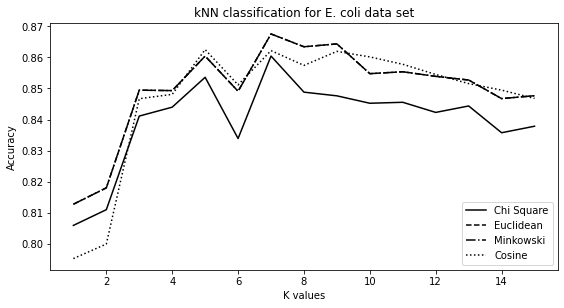

In [ ]:
# Repeat Steps 6 and 7 for e coli sets
import numpy as np 
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import scipy.spatial.distance as distance
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance

# init array of int [1:15] inclusive
num_nhbrs = np.arange(1,16)   
# init four distance metrics 
metric = [chi_square_distance, distance.euclidean, distance.minkowski, 
          distance.cosine]
# init dictionary to hold 
param_distribs = {'n_neighbors':num_nhbrs, 'metric': metric}
# instantiate kNN classifier 
estimator3 = KNeighborsClassifier()
# 10 fold cross validation 
skfold3 = RepeatedKFold(n_splits=10,n_repeats=10,random_state=1)
# search param space 
grid_search3 = GridSearchCV(estimator3, param_distribs, n_jobs=5,cv=skfold3)
# fit search to X and Y data (breast cancer)
grid_search3.fit(ecoli_features, ecoli_labels)

# Pt I: Create a df from the cv_resutls
df_cv = pd.DataFrame(grid_search3.cv_results_)
df_cv32 = df_cv[['param_n_neighbors', 'param_metric', 'mean_test_score']]

# break new df into subclasses by distance measure  
chi_sq = df_cv32[df_cv32['param_metric'].astype(str).str.contains("chi_square")].reset_index(drop=True)
euclid = df_cv32[df_cv32['param_metric'].astype(str).str.contains("euclidean")].reset_index(drop=True)
minkowski = df_cv32[df_cv32['param_metric'].astype(str).str.contains("minkowski")].reset_index(drop=True)
cosine = df_cv32[df_cv32['param_metric'].astype(str).str.contains("cosine")].reset_index(drop=True)

# Pt II: Visualize the results (with values of K on the x-axis and accuracy on 
# the y-axis) for all four metrics over three datasets using matplotlib. 

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)  
plt.plot(chi_sq['param_n_neighbors'], chi_sq['mean_test_score'], 
         label = 'Chi Square', color = 'k')
plt.plot(euclid['param_n_neighbors'], euclid['mean_test_score'], 
         label = 'Euclidean', color = 'k', linestyle = '--')
plt.plot(minkowski['param_n_neighbors'], minkowski['mean_test_score'], 
         label = 'Minkowski', color = 'k', linestyle = '-.')
plt.plot(cosine['param_n_neighbors'], cosine['mean_test_score'], 
         label = 'Cosine', color = 'k', linestyle = ':')
plt.title('kNN classification for E. coli data set')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
# Step 7 (cont)

# Pt III: Report the best cross-validation score on three datasets

# get best models 
best_model = grid_search.best_estimator_
best_model2 = grid_search2.best_estimator_
best_model3 = grid_search3.best_estimator_

# Pt III: Report the best cross-validation score on three datasets
print('Cross-validation on breast cancer data: {:.3f}' 
      .format(cross_val_score(estimator, breast_cancer_encoded , 
                              breast_cancer_labels ,cv=10).mean()))
print('Cross-validation on training set: {:.3f}' 
      .format(cross_val_score(estimator2, transfusion_features , 
                              transfusion_labels ,cv=10).mean()))
print('Cross-validation on training set: {:.3f}'.format(
    cross_val_score(estimator3,ecoli_features,ecoli_labels,cv=10).mean()))

Cross-validation on breast cancer data: 0.656
Cross-validation on training set: 0.661
Cross-validation on training set: 0.842


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


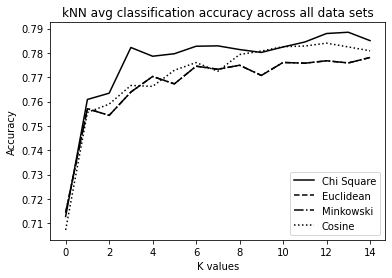

In [ ]:
# Step 8: You need to average classification accuracy of k-NN over three 
# datasets and visualize the results as shown in Figure 8 in the paper.   

k_avgs = np.zeros((len(df_cv2),2))  # init empty array to hold avgs 

for i in range(len(df_cv12)):
  sum = df_cv12.iloc[i,2] + df_cv22.iloc[i,2] + df_cv32.iloc[i,2]  # sum each k 
  avg = sum / 3  # calc avg k score 
  k_avgs[i,0] = avg  # store in array 

k_avgs = pd.DataFrame(k_avgs)  # convert to dataframe 
k_avgs[1] = df_cv12['param_metric']  # store distance type in dataframe 

# break new df into subclasses by distance measure  
chi_sq_avg = k_avgs[k_avgs[1].astype(str).str.contains("chi_square")].reset_index(drop=True)
euclid_avg = k_avgs[k_avgs[1].astype(str).str.contains("euclidean")].reset_index(drop=True)
minkowski_avg = k_avgs[k_avgs[1].astype(str).str.contains("minkowski")].reset_index(drop=True)
cosine_avg = k_avgs[k_avgs[1].astype(str).str.contains("cosine")].reset_index(drop=True)

x_axis = np.arange(1,16)

plt.plot(chi_sq_avg.index, chi_sq_avg[0],
         label = 'Chi Square', color = 'k')
plt.plot(euclid_avg.index, euclid_avg[0], 
         label = 'Euclidean', color = 'k', linestyle = '--')
plt.plot(minkowski_avg.index, minkowski_avg[0], 
         label = 'Minkowski', color = 'k', linestyle = '-.')
plt.plot(cosine_avg.index, cosine_avg[0], 
         label = 'Cosine', color = 'k', linestyle = ':')
plt.title('kNN avg classification accuracy across all data sets')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()